# Imports nécessaires à l'ensemble du projet de TLN

In [18]:
import pandas as pd
import numpy as np
import xml.etree.ElementTree as et 
import matplotlib.pyplot as plt
import time
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import en_core_web_sm
import nltk
from nltk import ne_chunk, pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('sentiwordnet')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\Alexis\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Alexis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alexis\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

# TP ANALYSE DE SENTIMENT  RESTAURANTS
Le jeu de données Restaurant_Train est composé de 3041 phrases en anglais tirées des critiques de restaurants. Les valeurs possibles pour la polarité des aspects sont : “positive”, “negative”, “conflict”, “neutral”. Les valeurs possibles des categories sont : “food”, “service”, “price”, “ambience”, “anecdotes/miscellaneous”.

Dans cette partie nous allons effectuer différents traitements :
* Création des dataframes (TRAIN et TEST GOLD)
* Tokenize et Pos Tags
* Partie sentiments
  * Assignation de la polarité de chaque mot 
  * Ajout des polarités dans les dataframes
  * Tri dans les dataframes
* Visualisation
  * Repartition de la polarite
  * Conversion des dataframes en listes
* Vectorisation — TF/IDF
  * Fréquence de terme/Fréquence de document inverse (TF/IDF)
  * Premier test avec seulement la colonne text comme variable explicative
  * Normalisation des dimensions de nos listes.
  * Vectorisation avec TfidfTransformer


## Création des dataframes

In [9]:
#  CREATE TRAIN DATAFRAME 
l = []

xtree = et.parse("Restaurants_Train.xml")
xroot = xtree.getroot()
for sentence in xroot.findall('sentence'):
    idi = sentence.get('id')
    text = sentence.find('text').text

    for neighbor in sentence.iter('aspectTerm'):
        # On mets 'id' et 'text' dans le dictionnaire avec toutes les variable qui nous intéresse
        neighbor.attrib['id'] = idi
        neighbor.attrib['text'] = text
        # on stock tous les dictionnaires crées dans une liste
        l.append(neighbor.attrib)
        
df_train = pd.DataFrame(l)
df_train.head(5)

,term,polarity,from,to,id,text
0,staff,negative,8,13,3121,But the staff was so horrible to us.
1,food,positive,57,61,2777,"To be completely fair, the only redeeming fact..."
2,food,positive,4,8,1634,"The food is uniformly exceptional, with a very..."
3,kitchen,positive,55,62,1634,"The food is uniformly exceptional, with a very..."
4,menu,neutral,141,145,1634,"The food is uniformly exceptional, with a very..."


In [10]:
#  CREATE Test GOLD DATAFRAME 
l = []

xtreeGoldTest = et.parse("Restaurants_Test_Gold.xml")
xroot = xtreeGoldTest.getroot()
for sentence in xroot.findall('sentence'):
    idi = sentence.get('id')
    text = sentence.find('text').text
    
    #print(idi, text)
    for neighbor in sentence.iter('aspectTerm'):
        # On mets 'id' et 'text' dans le dictionnaire avec toutes les variable qui nous intéresse
        neighbor.attrib['id'] = idi
        neighbor.attrib['text'] = text
        # on stock tous les dictionnaires crées dans une liste
        l.append(neighbor.attrib)
df_testGold = pd.DataFrame(l)
df_testGold.head(5)

,term,polarity,from,to,id,text
0,appetizers,positive,8,18,813,"All the appetizers and salads were fabulous, t..."
1,salads,positive,23,29,813,"All the appetizers and salads were fabulous, t..."
2,steak,positive,49,54,813,"All the appetizers and salads were fabulous, t..."
3,pasta,positive,82,87,813,"All the appetizers and salads were fabulous, t..."
4,portions,positive,17,25,1579,And really large portions.


## Tokenize et Pos Tag

In [11]:
#  TOKENIZE & POS TAG du TRAIN 
nlp = en_core_web_sm.load()

df_train['token_text'] = df_train.apply(lambda row: nlp(row["text"]), axis=1)

df_train

,term,polarity,from,to,id,text,token_text
0,staff,negative,8,13,3121,But the staff was so horrible to us.,"(But, the, staff, was, so, horrible, to, us, .)"
1,food,positive,57,61,2777,"To be completely fair, the only redeeming fact...","(To, be, completely, fair, ,, the, only, redee..."
2,food,positive,4,8,1634,"The food is uniformly exceptional, with a very...","(The, food, is, uniformly, exceptional, ,, wit..."
3,kitchen,positive,55,62,1634,"The food is uniformly exceptional, with a very...","(The, food, is, uniformly, exceptional, ,, wit..."
4,menu,neutral,141,145,1634,"The food is uniformly exceptional, with a very...","(The, food, is, uniformly, exceptional, ,, wit..."
...,...,...,...,...,...,...,...
3688,pot of boiling water,neutral,17,37,671,Each table has a pot of boiling water sunken i...,"(Each, table, has, a, pot, of, boiling, water,..."
3689,meats,neutral,99,104,671,Each table has a pot of boiling water sunken i...,"(Each, table, has, a, pot, of, boiling, water,..."
3690,vegetables,neutral,114,124,671,Each table has a pot of boiling water sunken i...,"(Each, table, has, a, pot, of, boiling, water,..."
3691,rice,neutral,130,134,671,Each table has a pot of boiling water sunken i...,"(Each, table, has, a, pot, of, boiling, water,..."


In [12]:
# on vérifie que les posTag ont bien été conservés
df_train.token_text[0]
[X.pos_ for X in  df_train.token_text[0]]

['CCONJ', 'DET', 'NOUN', 'AUX', 'ADV', 'ADJ', 'ADP', 'PRON', 'PUNCT']

In [13]:
#  TOKENIZE & POS TAG TEST GOLD 
df_testGold['token_text'] = df_testGold.apply(lambda row: nlp(row["text"]), axis=1)

df_testGold

,term,polarity,from,to,id,text,token_text
0,appetizers,positive,8,18,813,"All the appetizers and salads were fabulous, t...","(All, the, appetizers, and, salads, were, fabu..."
1,salads,positive,23,29,813,"All the appetizers and salads were fabulous, t...","(All, the, appetizers, and, salads, were, fabu..."
2,steak,positive,49,54,813,"All the appetizers and salads were fabulous, t...","(All, the, appetizers, and, salads, were, fabu..."
3,pasta,positive,82,87,813,"All the appetizers and salads were fabulous, t...","(All, the, appetizers, and, salads, were, fabu..."
4,portions,positive,17,25,1579,And really large portions.,"(And, really, large, portions, .)"
...,...,...,...,...,...,...,...
91,sardines with biscuits,positive,77,99,2912,"The dishes offered were unique, very tasty and...","(The, dishes, offered, were, unique, ,, very, ..."
92,large whole shrimp,positive,101,119,2912,"The dishes offered were unique, very tasty and...","(The, dishes, offered, were, unique, ,, very, ..."
93,pistachio ice cream,positive,135,154,2912,"The dishes offered were unique, very tasty and...","(The, dishes, offered, were, unique, ,, very, ..."
94,office lunch,neutral,18,30,3188,Went there for an office lunch.,"(Went, there, for, an, office, lunch, .)"


## Partie Sentiments
### Assignation de la polarité de chaque mot & Ajout des polarités dans les dataframes

In [14]:
# Assigner la polarité de chaque mot et les ajouter dans les dataframes

df_train.insert(6,'Score_by_word',"")
df_testGold.insert(6,'Score_by_word',"")

df_train.insert(7,'Sentiword',"")
df_testGold.insert(7,'Sentiword',"")

df_testGold.head(4)

,term,polarity,from,to,id,text,Score_by_word,Sentiword,token_text
0,appetizers,positive,8,18,813,"All the appetizers and salads were fabulous, t...",,,"(All, the, appetizers, and, salads, were, fabu..."
1,salads,positive,23,29,813,"All the appetizers and salads were fabulous, t...",,,"(All, the, appetizers, and, salads, were, fabu..."
2,steak,positive,49,54,813,"All the appetizers and salads were fabulous, t...",,,"(All, the, appetizers, and, salads, were, fabu..."
3,pasta,positive,82,87,813,"All the appetizers and salads were fabulous, t...",,,"(All, the, appetizers, and, salads, were, fabu..."


In [15]:
def penn_to_wn(tag):
  """
  Convertion des tags en simple WORDNET TAGS
  """
  if tag.startswith('J'):
    return wn.ADJ
  elif tag.startswith('N'):
    return wn.NOUN
  elif tag.startswith('R'):
    return wn.ADV
  elif tag.startswith('V'):
    return wn.VERB
  return None

lemmatizer = WordNetLemmatizer()

# CHARGEMENT DES SENTIMENTS DETECTES
def get_sentiment(word,tag):
  """
  Return une liste de score positif negatif ou neutre et return une liste vide si le mot ne renvoie rien depuis senti wordnet.
  """
  wn_tag = penn_to_wn(tag)
  if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
    return []

  lemma = lemmatizer.lemmatize(word, pos=wn_tag)
  if not lemma:
    return []

  synsets = wn.synsets(word, pos=wn_tag)
  if not synsets:
    return []

  # Prend le premier sens du mot c'est à dire le sens le plus commun
  synset = synsets[0]
  swn_synset = swn.senti_synset(synset.name())

  return [swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score()]

In [19]:
# On remplit nos colonnes vides
#  TRAIN DATAFRAME  #
ps = PorterStemmer()
i=0
for token in df_train.text :
    words_data= nltk.word_tokenize(str(token))
    tokens_without_sw = [word for word in words_data if not word in stopwords.words()]


    pos_val = nltk.pos_tag(tokens_without_sw)


    scores = []
    words_sentence = []

    for (x,y) in pos_val :
        scores.append(get_sentiment(x,y))
        words_sentence.append(x)

    df_train['Sentiword'][i] = words_sentence
    df_train['Score_by_word'][i] = scores
    i+=1

df_train.head(10)

,term,polarity,from,to,id,text,Score_by_word,Sentiword,token_text
0,staff,negative,8,13,3121,But the staff was so horrible to us.,"[[], [0.0, 0.0, 1.0], [0.0, 0.625, 0.375], [],...","[But, staff, horrible, us, .]","(But, the, staff, was, so, horrible, to, us, .)"
1,food,positive,57,61,2777,"To be completely fair, the only redeeming fact...","[[], [0.5, 0.0, 0.5], [0.625, 0.0, 0.375], [],...","[To, completely, fair, ,, redeeming, factor, f...","(To, be, completely, fair, ,, the, only, redee..."
2,food,positive,4,8,1634,"The food is uniformly exceptional, with a very...","[[], [0.0, 0.0, 1.0], [], [], [], [0.125, 0.0,...","[The, food, uniformly, exceptional, ,, capable...","(The, food, is, uniformly, exceptional, ,, wit..."
3,kitchen,positive,55,62,1634,"The food is uniformly exceptional, with a very...","[[], [0.0, 0.0, 1.0], [], [], [], [0.125, 0.0,...","[The, food, uniformly, exceptional, ,, capable...","(The, food, is, uniformly, exceptional, ,, wit..."
4,menu,neutral,141,145,1634,"The food is uniformly exceptional, with a very...","[[], [0.0, 0.0, 1.0], [], [], [], [0.125, 0.0,...","[The, food, uniformly, exceptional, ,, capable...","(The, food, is, uniformly, exceptional, ,, wit..."
5,food,positive,17,21,2846,"Not only was the food outstanding, but the lit...","[[0.0, 0.625, 0.375], [0.0, 0.0, 1.0], [0.75, ...","[Not, food, outstanding, ,, little, 'perks, ',...","(Not, only, was, the, food, outstanding, ,, bu..."
6,perks,positive,51,56,2846,"Not only was the food outstanding, but the lit...","[[0.0, 0.625, 0.375], [0.0, 0.0, 1.0], [0.75, ...","[Not, food, outstanding, ,, little, 'perks, ',...","(Not, only, was, the, food, outstanding, ,, bu..."
7,orrechiete with sausage and chicken,positive,27,62,1458,Our agreed favorite is the orrechiete with sau...,"[[], [], [0.125, 0.0, 0.875], [], [0.25, 0.0, ...","[Our, agreed, favorite, orrechiete, sausage, c...","(Our, agreed, favorite, is, the, orrechiete, w..."
8,waiters,positive,76,83,1458,Our agreed favorite is the orrechiete with sau...,"[[], [], [0.125, 0.0, 0.875], [], [0.25, 0.0, ...","[Our, agreed, favorite, orrechiete, sausage, c...","(Our, agreed, favorite, is, the, orrechiete, w..."
9,meats,neutral,152,157,1458,Our agreed favorite is the orrechiete with sau...,"[[], [], [0.125, 0.0, 0.875], [], [0.25, 0.0, ...","[Our, agreed, favorite, orrechiete, sausage, c...","(Our, agreed, favorite, is, the, orrechiete, w..."


In [20]:
# On remplit nos  colonnes vides
#  TEST DATAFRAME  #
ps = PorterStemmer()
i=0
for token in df_testGold.text :
    words_data= nltk.word_tokenize(str(token))
    tokens_without_sw = [word for word in words_data if not word in stopwords.words()]


    pos_val = nltk.pos_tag(tokens_without_sw)


    scores = []
    words_sentence = []

    for (x,y) in pos_val :
        scores.append(get_sentiment(x,y))
        words_sentence.append(x)

    df_testGold['Sentiword'][i] = words_sentence
    df_testGold['Score_by_word'][i] = scores
    i+=1

df_testGold.head(10)

,term,polarity,from,to,id,text,Score_by_word,Sentiword,token_text
0,appetizers,positive,8,18,813,"All the appetizers and salads were fabulous, t...","[[], [0.0, 0.0, 1.0], [], [0.875, 0.125, 0.0],...","[All, appetizers, salads, fabulous, ,, steak, ...","(All, the, appetizers, and, salads, were, fabu..."
1,salads,positive,23,29,813,"All the appetizers and salads were fabulous, t...","[[], [0.0, 0.0, 1.0], [], [0.875, 0.125, 0.0],...","[All, appetizers, salads, fabulous, ,, steak, ...","(All, the, appetizers, and, salads, were, fabu..."
2,steak,positive,49,54,813,"All the appetizers and salads were fabulous, t...","[[], [0.0, 0.0, 1.0], [], [0.875, 0.125, 0.0],...","[All, appetizers, salads, fabulous, ,, steak, ...","(All, the, appetizers, and, salads, were, fabu..."
3,pasta,positive,82,87,813,"All the appetizers and salads were fabulous, t...","[[], [0.0, 0.0, 1.0], [], [0.875, 0.125, 0.0],...","[All, appetizers, salads, fabulous, ,, steak, ...","(All, the, appetizers, and, salads, were, fabu..."
4,portions,positive,17,25,1579,And really large portions.,"[[], [0.625, 0.0, 0.375], [0.25, 0.125, 0.625]...","[And, really, large, portions, .]","(And, really, large, portions, .)"
5,sweet lassi,positive,4,15,2882,The sweet lassi was excellent as was the lamb ...,"[[], [0.0, 0.0, 1.0], [], [1.0, 0.0, 0.0], [0....","[The, sweet, lassi, excellent, lamb, chettinad...","(The, sweet, lassi, was, excellent, as, was, t..."
6,lamb chettinad,positive,41,55,2882,The sweet lassi was excellent as was the lamb ...,"[[], [0.0, 0.0, 1.0], [], [1.0, 0.0, 0.0], [0....","[The, sweet, lassi, excellent, lamb, chettinad...","(The, sweet, lassi, was, excellent, as, was, t..."
7,garlic naan,positive,64,75,2882,The sweet lassi was excellent as was the lamb ...,"[[], [0.0, 0.0, 1.0], [], [1.0, 0.0, 0.0], [0....","[The, sweet, lassi, excellent, lamb, chettinad...","(The, sweet, lassi, was, excellent, as, was, t..."
8,rasamalai,negative,84,93,2882,The sweet lassi was excellent as was the lamb ...,"[[], [0.0, 0.0, 1.0], [], [1.0, 0.0, 0.0], [0....","[The, sweet, lassi, excellent, lamb, chettinad...","(The, sweet, lassi, was, excellent, as, was, t..."
9,Service,positive,0,7,1609,Service was quick.,"[[0.0, 0.0, 1.0], [0.0, 0.0, 1.0], []]","[Service, quick, .]","(Service, was, quick, .)"


In [21]:
# On ajoute une colonne avec seulement les POStag
# (il est plus facile de retirer des colonnes que d'en ajouter plus tard)

df_train.insert(7,'PosTag',"")
df_testGold.insert(7,'PosTag',"")

df_testGold.head(3)

,term,polarity,from,to,id,text,Score_by_word,PosTag,Sentiword,token_text
0,appetizers,positive,8,18,813,"All the appetizers and salads were fabulous, t...","[[], [0.0, 0.0, 1.0], [], [0.875, 0.125, 0.0],...",,"[All, appetizers, salads, fabulous, ,, steak, ...","(All, the, appetizers, and, salads, were, fabu..."
1,salads,positive,23,29,813,"All the appetizers and salads were fabulous, t...","[[], [0.0, 0.0, 1.0], [], [0.875, 0.125, 0.0],...",,"[All, appetizers, salads, fabulous, ,, steak, ...","(All, the, appetizers, and, salads, were, fabu..."
2,steak,positive,49,54,813,"All the appetizers and salads were fabulous, t...","[[], [0.0, 0.0, 1.0], [], [0.875, 0.125, 0.0],...",,"[All, appetizers, salads, fabulous, ,, steak, ...","(All, the, appetizers, and, salads, were, fabu..."


In [22]:
# On remplit 
for i in range(len(df_train.PosTag)):
    df_train['PosTag'][i] = [(X.pos_) for X in  df_train.token_text[i]]

for i in range(len(df_testGold.PosTag)):
    df_testGold['PosTag'][i] = [(X.pos_) for X in  df_testGold.token_text[i]]



In [23]:
df_train.head(3) 

,term,polarity,from,to,id,text,Score_by_word,PosTag,Sentiword,token_text
0,staff,negative,8,13,3121,But the staff was so horrible to us.,"[[], [0.0, 0.0, 1.0], [0.0, 0.625, 0.375], [],...","[CCONJ, DET, NOUN, AUX, ADV, ADJ, ADP, PRON, P...","[But, staff, horrible, us, .]","(But, the, staff, was, so, horrible, to, us, .)"
1,food,positive,57,61,2777,"To be completely fair, the only redeeming fact...","[[], [0.5, 0.0, 0.5], [0.625, 0.0, 0.375], [],...","[PART, AUX, ADV, ADJ, PUNCT, DET, ADJ, VERB, N...","[To, completely, fair, ,, redeeming, factor, f...","(To, be, completely, fair, ,, the, only, redee..."
2,food,positive,4,8,1634,"The food is uniformly exceptional, with a very...","[[], [0.0, 0.0, 1.0], [], [], [], [0.125, 0.0,...","[DET, NOUN, AUX, ADV, ADJ, PUNCT, ADP, DET, AD...","[The, food, uniformly, exceptional, ,, capable...","(The, food, is, uniformly, exceptional, ,, wit..."


In [24]:
df_testGold.head(3)

,term,polarity,from,to,id,text,Score_by_word,PosTag,Sentiword,token_text
0,appetizers,positive,8,18,813,"All the appetizers and salads were fabulous, t...","[[], [0.0, 0.0, 1.0], [], [0.875, 0.125, 0.0],...","[DET, DET, NOUN, CCONJ, NOUN, AUX, ADJ, PUNCT,...","[All, appetizers, salads, fabulous, ,, steak, ...","(All, the, appetizers, and, salads, were, fabu..."
1,salads,positive,23,29,813,"All the appetizers and salads were fabulous, t...","[[], [0.0, 0.0, 1.0], [], [0.875, 0.125, 0.0],...","[DET, DET, NOUN, CCONJ, NOUN, AUX, ADJ, PUNCT,...","[All, appetizers, salads, fabulous, ,, steak, ...","(All, the, appetizers, and, salads, were, fabu..."
2,steak,positive,49,54,813,"All the appetizers and salads were fabulous, t...","[[], [0.0, 0.0, 1.0], [], [0.875, 0.125, 0.0],...","[DET, DET, NOUN, CCONJ, NOUN, AUX, ADJ, PUNCT,...","[All, appetizers, salads, fabulous, ,, steak, ...","(All, the, appetizers, and, salads, were, fabu..."


### Tri dans les dataframes
#### Colonnes à conserver
* Variables explicatives/prédictives :
  * term
  * text
  * Score_by_word
  * PosTag
  * Sentiword
* Label à prédire :
  * polarity

In [26]:
#  TRAIN DATAFRAME  #
DF_train = df_train[['term','text','PosTag','Sentiword','Score_by_word','polarity','token_text']]
DF_train.head(3)

,term,text,PosTag,Sentiword,Score_by_word,polarity,token_text
0,staff,But the staff was so horrible to us.,"[CCONJ, DET, NOUN, AUX, ADV, ADJ, ADP, PRON, P...","[But, staff, horrible, us, .]","[[], [0.0, 0.0, 1.0], [0.0, 0.625, 0.375], [],...",negative,"(But, the, staff, was, so, horrible, to, us, .)"
1,food,"To be completely fair, the only redeeming fact...","[PART, AUX, ADV, ADJ, PUNCT, DET, ADJ, VERB, N...","[To, completely, fair, ,, redeeming, factor, f...","[[], [0.5, 0.0, 0.5], [0.625, 0.0, 0.375], [],...",positive,"(To, be, completely, fair, ,, the, only, redee..."
2,food,"The food is uniformly exceptional, with a very...","[DET, NOUN, AUX, ADV, ADJ, PUNCT, ADP, DET, AD...","[The, food, uniformly, exceptional, ,, capable...","[[], [0.0, 0.0, 1.0], [], [], [], [0.125, 0.0,...",positive,"(The, food, is, uniformly, exceptional, ,, wit..."


In [27]:
#  TEST DATAFRAME  #
DF_test = df_testGold[['term','text','PosTag','Sentiword','Score_by_word','polarity','token_text']]
DF_test.head(3)

,term,text,PosTag,Sentiword,Score_by_word,polarity,token_text
0,appetizers,"All the appetizers and salads were fabulous, t...","[DET, DET, NOUN, CCONJ, NOUN, AUX, ADJ, PUNCT,...","[All, appetizers, salads, fabulous, ,, steak, ...","[[], [0.0, 0.0, 1.0], [], [0.875, 0.125, 0.0],...",positive,"(All, the, appetizers, and, salads, were, fabu..."
1,salads,"All the appetizers and salads were fabulous, t...","[DET, DET, NOUN, CCONJ, NOUN, AUX, ADJ, PUNCT,...","[All, appetizers, salads, fabulous, ,, steak, ...","[[], [0.0, 0.0, 1.0], [], [0.875, 0.125, 0.0],...",positive,"(All, the, appetizers, and, salads, were, fabu..."
2,steak,"All the appetizers and salads were fabulous, t...","[DET, DET, NOUN, CCONJ, NOUN, AUX, ADJ, PUNCT,...","[All, appetizers, salads, fabulous, ,, steak, ...","[[], [0.0, 0.0, 1.0], [], [0.875, 0.125, 0.0],...",positive,"(All, the, appetizers, and, salads, were, fabu..."


In [28]:
# sauvegarder en Dataframe grace à .pkl
df_train.to_pickle('df_train_PANDAS_DATAFRAME.pkl')  
df_testGold.to_pickle('df_test_PANDAS_DATAFRAME.pkl')

#Pour recharger les dataframe : 
df_train = pd.read_pickle('df_train_PANDAS_DATAFRAME.pkl')
df_testGold = pd.read_pickle('df_test_PANDAS_DATAFRAME.pkl')

df_train.head(3)

,term,polarity,from,to,id,text,Score_by_word,PosTag,Sentiword,token_text
0,staff,negative,8,13,3121,But the staff was so horrible to us.,"[[], [0.0, 0.0, 1.0], [0.0, 0.625, 0.375], [],...","[CCONJ, DET, NOUN, AUX, ADV, ADJ, ADP, PRON, P...","[But, staff, horrible, us, .]","(But, the, staff, was, so, horrible, to, us, .)"
1,food,positive,57,61,2777,"To be completely fair, the only redeeming fact...","[[], [0.5, 0.0, 0.5], [0.625, 0.0, 0.375], [],...","[PART, AUX, ADV, ADJ, PUNCT, DET, ADJ, VERB, N...","[To, completely, fair, ,, redeeming, factor, f...","(To, be, completely, fair, ,, the, only, redee..."
2,food,positive,4,8,1634,"The food is uniformly exceptional, with a very...","[[], [0.0, 0.0, 1.0], [], [], [], [0.125, 0.0,...","[DET, NOUN, AUX, ADV, ADJ, PUNCT, ADP, DET, AD...","[The, food, uniformly, exceptional, ,, capable...","(The, food, is, uniformly, exceptional, ,, wit..."


## Visualisation
Générer une visualisation des données à travers des graphiques pour montrer combien de mots ont une polarité positive / negative dans chaque fichier.

### Repartition de la polarite

(array([[ 805.,    0.,    0., 2164.,    0.,    0.,  633.,    0.,    0.,
           91.],
        [  18.,    0.,    0.,   68.,    0.,    0.,   10.,    0.,    0.,
            0.]]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 2 BarContainer objects>)

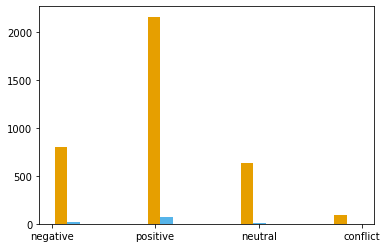

In [29]:
x1 = DF_train['polarity']
x2 = DF_test['polarity']

# on assigne une couleur unique (plus lisible sur le graphique)
colors = ['#E69F00', '#56B4E9']
names = ['TRAIN', 'TEST']
         

plt.hist([x1, x2],color = colors, label=names)

Les nombres n'étant pas très pertinents pour étudier la répartition nous regarderons plutôt le pourcentage. De plus le pourcentage offre une meilleure visualisation de la répartition.

In [30]:
# NOMBRES
## TRAIN
posTrain=len(DF_train[DF_train['polarity'] == 'positive' ].index)
negTrain=len(DF_train[DF_train['polarity'] == 'negative' ].index)
neuTrain=len(DF_train[DF_train['polarity'] == 'neutral' ].index)
confTrain=len(DF_train[DF_train['polarity'] == 'conflict' ].index)

## TEST
posTest=len(DF_test[DF_test['polarity'] == 'positive' ].index)
negTest=len(DF_test[DF_test['polarity'] == 'negative' ].index)
neuTest=len(DF_test[DF_test['polarity'] == 'neutral' ].index)
confTest=len(DF_test[DF_test['polarity'] == 'conflict' ].index)

print("### TRAIN ###")
print("Nombre de positif : ",posTrain,", Nombre de negatif : ",negTrain,", Nombre de neutre : ",neuTrain,", Nombre de conflits : ",confTrain)
print("### TEST ###")
print("Nombre de positif : ",posTest,", Nombre de negatif : ",negTest,", Nombre de neutre : ",neuTest,", Nombre de conflits : ",confTest)

# TAUX
## TRAIN
pos_train=len(DF_train[DF_train['polarity'] == 'positive' ].index)/len(DF_train)*100
neg_train=len(DF_train[DF_train['polarity'] == 'negative' ].index)/len(DF_train)*100
neu_train=len(DF_train[DF_train['polarity'] == 'neutral' ].index)/len(DF_train)*100
conf_train=len(DF_train[DF_train['polarity'] == 'conflict' ].index)/len(DF_train)*100

## TEST
pos_test=len(DF_test[DF_test['polarity'] == 'positive' ].index)/len(DF_test)*100
neg_test=len(DF_test[DF_test['polarity'] == 'negative' ].index)/len(DF_test)*100
neu_test=len(DF_test[DF_test['polarity'] == 'neutral' ].index)/len(DF_test)*100
conf_test=len(DF_test[DF_test['polarity'] == 'conflict' ].index)/len(DF_test)*100

print("### TRAIN ###")
print("Positive : ",pos_train," %, Negative : ",neg_train," %, Neutral : ",neu_train," %, Conflicts : ",conf_train, " %")
print("### TEST ###")
print("Positive : ",pos_test," %, Negative : ",neg_test," %, Neutral : ",neu_test," %, Conflicts : ",conf_test, " %")

### TRAIN ###
Nombre de positif :  2164 , Nombre de negatif :  805 , Nombre de neutre :  633 , Nombre de conflits :  91
### TEST ###
Nombre de positif :  68 , Nombre de negatif :  18 , Nombre de neutre :  10 , Nombre de conflits :  0
### TRAIN ###
Positive :  58.59734633089629  %, Negative :  21.797996209044136  %, Neutral :  17.140536149471973  %, Conflicts :  2.464121310587598  %
### TEST ###
Positive :  70.83333333333334  %, Negative :  18.75  %, Neutral :  10.416666666666668  %, Conflicts :  0.0  %


Text(0.5, 1.0, 'Répartition en % des données en fonctions de leurs polarités ')

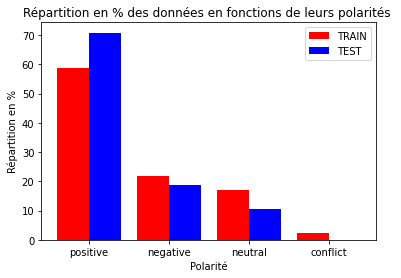

In [31]:
# Affichage au format Histogramme
barWidth = 0.4
train = [pos_train, neg_train, neu_train, conf_train]
test = [pos_test, neg_test, neu_test, conf_test]
r1 = range(len(train))
r2 = [x + barWidth for x in r1]

plotTrain= plt.bar(r1, train, width = barWidth, color = ['red' for i in train])
plotTest= plt.bar(r2, test, width = barWidth, color = ['blue' for i in train])
plt.xticks([r + barWidth / 2 for r in range(len(train))], ['positive', 'negative', 'neutral','conflict'])
plt.legend([plotTrain, plotTest], ['TRAIN', 'TEST'])
plt.xlabel("Polarité")
plt.ylabel("Répartition en %")
plt.title("Répartition en % des données en fonctions de leurs polarités ")

Il n'y a pas de "conflict" dans l'ensemble de test, on ne prendra donc pas en compte ces valeurs.

Cependant, les autres classes semblents, d'après le graph, bien réparties

In [32]:
# On récupère les indexes qui contiennent des "conflicts"
indexNames = DF_train[DF_train['polarity'] == 'conflict' ].index
# on retire les lignes concernées
DF_train.drop(indexNames , inplace=True)

# On récupère les indexes qui contiennent des "conflicts"
indexNames = DF_test[DF_test['polarity'] == 'conflict' ].index
# on retire les lignes concernées
DF_test.drop(indexNames , inplace=True)

F:\COURS\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [33]:
# On récupère les indexes qui contiennent des "conflicts"
indexNames = DF_train[DF_train['polarity'] == 'conflict' ].index

# On récupère les indexes qui contiennent des "conflicts"
indexNames = DF_test[DF_test['polarity'] == 'conflict' ].index

In [34]:
# Save 
DF_train.to_pickle('DF_train_PANDAS_DATAFRAME.pkl')  
DF_test.to_pickle('DF_test_PANDAS_DATAFRAME.pkl')  

#Pour recharger les dataframe : 
DF_train = pd.read_pickle('DF_train_PANDAS_DATAFRAME.pkl')
DF_test = pd.read_pickle('DF_test_PANDAS_DATAFRAME.pkl')

In [35]:
DF_train.head(3)

,term,text,PosTag,Sentiword,Score_by_word,polarity,token_text
0,staff,But the staff was so horrible to us.,"[CCONJ, DET, NOUN, AUX, ADV, ADJ, ADP, PRON, P...","[But, staff, horrible, us, .]","[[], [0.0, 0.0, 1.0], [0.0, 0.625, 0.375], [],...",negative,"(But, the, staff, was, so, horrible, to, us, .)"
1,food,"To be completely fair, the only redeeming fact...","[PART, AUX, ADV, ADJ, PUNCT, DET, ADJ, VERB, N...","[To, completely, fair, ,, redeeming, factor, f...","[[], [0.5, 0.0, 0.5], [0.625, 0.0, 0.375], [],...",positive,"(To, be, completely, fair, ,, the, only, redee..."
2,food,"The food is uniformly exceptional, with a very...","[DET, NOUN, AUX, ADV, ADJ, PUNCT, ADP, DET, AD...","[The, food, uniformly, exceptional, ,, capable...","[[], [0.0, 0.0, 1.0], [], [], [], [0.125, 0.0,...",positive,"(The, food, is, uniformly, exceptional, ,, wit..."


In [36]:
DF_test.head(3)

,term,text,PosTag,Sentiword,Score_by_word,polarity,token_text
0,appetizers,"All the appetizers and salads were fabulous, t...","[DET, DET, NOUN, CCONJ, NOUN, AUX, ADJ, PUNCT,...","[All, appetizers, salads, fabulous, ,, steak, ...","[[], [0.0, 0.0, 1.0], [], [0.875, 0.125, 0.0],...",positive,"(All, the, appetizers, and, salads, were, fabu..."
1,salads,"All the appetizers and salads were fabulous, t...","[DET, DET, NOUN, CCONJ, NOUN, AUX, ADJ, PUNCT,...","[All, appetizers, salads, fabulous, ,, steak, ...","[[], [0.0, 0.0, 1.0], [], [0.875, 0.125, 0.0],...",positive,"(All, the, appetizers, and, salads, were, fabu..."
2,steak,"All the appetizers and salads were fabulous, t...","[DET, DET, NOUN, CCONJ, NOUN, AUX, ADJ, PUNCT,...","[All, appetizers, salads, fabulous, ,, steak, ...","[[], [0.0, 0.0, 1.0], [], [0.875, 0.125, 0.0],...",positive,"(All, the, appetizers, and, salads, were, fabu..."


### Conversion des dataframes en listes
Cela va permettre la vectorisation par la suite.

In [37]:
print("DataFrame after reset_index:")
DF_train.reset_index(inplace=True, drop=False)

DataFrame after reset_index:


In [38]:
# TRAIN DATASET
df_train = DF_train

list_train = []
label_train = []
print(df_train)
for i in range(len(df_train)):
    pos_tag = [X.pos_ for X in  df_train.token_text[i]]
    pos_tag_text = " ".join(pos_tag)
    senti_word = " ".join(df_train.Sentiword[i])
    score_by_word = ",".join(str(v) for v in df_train.Score_by_word[i])
    
    list_train.append(
        (df_train.term[i],
        df_train.text[i],
        pos_tag_text,
        senti_word,
        score_by_word,
        ))
    label_train.append(df_train.polarity[i])

list_train

Restaurant_Train = np.array(list_train)
print(Restaurant_Train)


      index                  term  \
0         0                 staff   
1         1                  food   
2         2                  food   
3         3               kitchen   
4         4                  menu   
...     ...                   ...   
3597   3688  pot of boiling water   
3598   3689                 meats   
3599   3690            vegetables   
3600   3691                  rice   
3601   3692         glass noodles   

                                                   text  \
0                  But the staff was so horrible to us.   
1     To be completely fair, the only redeeming fact...   
2     The food is uniformly exceptional, with a very...   
3     The food is uniformly exceptional, with a very...   
4     The food is uniformly exceptional, with a very...   
...                                                 ...   
3597  Each table has a pot of boiling water sunken i...   
3598  Each table has a pot of boiling water sunken i...   
3599  Each table has a p

In [39]:
# TEST DATASET
df_test = DF_test

list_test = []
label_test = []

for i in range(len(df_test)):
    pos_tag = [X.pos_ for X in  df_test.token_text[i]]
    pos_tag_text = " ".join(pos_tag)
    senti_word = " ".join(df_test.Sentiword[i])
    score_by_word = ",".join(str(v) for v in df_test.Score_by_word[i])
    
    list_test.append(
        (df_test.term[i],
        df_test.text[i],
        pos_tag_text,
        senti_word,
        score_by_word,
        ))
    label_test.append(df_test.polarity[i])


import numpy as np
Restaurant_Test = np.array(list_test)
print(Restaurant_Test)


[['appetizers'
  'All the appetizers and salads were fabulous, the steak was mouth watering and the pasta was delicious!!!'
  'DET DET NOUN CCONJ NOUN AUX ADJ PUNCT DET NOUN AUX NOUN NOUN CCONJ DET NOUN AUX ADJ PUNCT PUNCT PUNCT'
  'All appetizers salads fabulous , steak mouth watering pasta delicious ! ! !'
  '[],[0.0, 0.0, 1.0],[],[0.875, 0.125, 0.0],[],[],[0.0, 0.0, 1.0],[],[0.0, 0.0, 1.0],[0.75, 0.0, 0.25],[],[],[]']
 ['salads'
  'All the appetizers and salads were fabulous, the steak was mouth watering and the pasta was delicious!!!'
  'DET DET NOUN CCONJ NOUN AUX ADJ PUNCT DET NOUN AUX NOUN NOUN CCONJ DET NOUN AUX ADJ PUNCT PUNCT PUNCT'
  'All appetizers salads fabulous , steak mouth watering pasta delicious ! ! !'
  '[],[0.0, 0.0, 1.0],[],[0.875, 0.125, 0.0],[],[],[0.0, 0.0, 1.0],[],[0.0, 0.0, 1.0],[0.75, 0.0, 0.25],[],[],[]']
 ['steak'
  'All the appetizers and salads were fabulous, the steak was mouth watering and the pasta was delicious!!!'
  'DET DET NOUN CCONJ NOUN AUX ADJ 

## Vectorisation — TF/IDF

* Aux fins de la plupart des modélisations mathématiques effectuées sur le texte et aux fins de cette expérimentation, différents processus de « vectorisation » ont été mis en oeuvre.

* Le contenu textuel seul ne peut pas être modifié et contraint dans l'espace mathématique sans être transformé en nombres dans le but d'être lu par un algorithme d'apprentissage automatique.

* C'est pourquoi pour les besoins des méthodes supervisées dans ce projet, différents types de vectorisation ont été utilisés pour convertir des données qualitatives en données quantitatives afin de les manipuler mathématiquement. Ces vecteurs deviennent des caractéristiques intégrées pour les modèles.

### Fréquence de terme/Fréquence de document inverse (TF/IDF)
Il s'agit de la technique de vectorisation utilisée pour le modèle Support Vector Machine.

* TF/IDF a été déployé sur les données d'entraînement avec une approche unigramme qui compte chaque mot individuel comme un terme. La « fréquence des termes » correspond à la fréquence à laquelle un certain mot apparaît dans le texte, la « fréquence inverse du document » fait référence à la réduction de la signification des mots qui apparaissent le plus souvent dans tout le texte.
* Cela sert à faire des mots que l'on voit fréquemment dans un document donné mais pas nécessairement dans tous les documents.

### Premier test avec seulement la colonne text comme variable explicative
Ce premier test ne signifie pas grand chose, mais il permet de montrer l'efficacité de SVM. Il doit prédire sans savoir le term à analyser, et donc sans savoir pourquoi la même phrase peut avoir une polarité positive et parfois négative.

In [40]:
# Create feature vectors
vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)

train_vectors = vectorizer.fit_transform(DF_train['text'])
test_vectors = vectorizer.transform(DF_test['text'])

# Perform classification with SVM, kernel=linear
classifier_linear = svm.SVC(kernel='linear')
t0 = time.time()
classifier_linear.fit(train_vectors, DF_train['polarity'])
t1 = time.time()
prediction_linear = classifier_linear.predict(test_vectors)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1

# Resultats
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))

report = classification_report(DF_test['polarity'], prediction_linear, output_dict=True)


print('positive: ', report['positive'])
print('negative: ', report['negative'])
print('neutral: ', report['neutral'])

Training time: 1.031386s; Prediction time: 0.019516s
positive:  {'precision': 0.868421052631579, 'recall': 0.9705882352941176, 'f1-score': 0.9166666666666667, 'support': 68}
negative:  {'precision': 0.875, 'recall': 0.7777777777777778, 'f1-score': 0.823529411764706, 'support': 18}
neutral:  {'precision': 0.75, 'recall': 0.3, 'f1-score': 0.4285714285714285, 'support': 10}


Là, notre modèle prédit positif ou négatif sans savoir le term dont il s'agit. Il n'a que les phrases pour prédire. Donc ce n'est pas ce que nosu cherchons à observer.

### Normalisation des dimensions de nos listes.
Afin d'avoir le même nombres de features dans chaque liste

In [41]:
### TEST ###
L = len(Restaurant_Test)
X_test = []
y_test = []
for i in range(0,L):
    X_test.append(Restaurant_Test[i][0] + " " + Restaurant_Test[i][1] + " " + Restaurant_Test[i][2] + " " + Restaurant_Test[i][3]+ " " + Restaurant_Test[i][4])
    y_test.append(label_test[i])

X_test[0:3]

['appetizers All the appetizers and salads were fabulous, the steak was mouth watering and the pasta was delicious!!! DET DET NOUN CCONJ NOUN AUX ADJ PUNCT DET NOUN AUX NOUN NOUN CCONJ DET NOUN AUX ADJ PUNCT PUNCT PUNCT All appetizers salads fabulous , steak mouth watering pasta delicious ! ! ! [],[0.0, 0.0, 1.0],[],[0.875, 0.125, 0.0],[],[],[0.0, 0.0, 1.0],[],[0.0, 0.0, 1.0],[0.75, 0.0, 0.25],[],[],[]',
 'salads All the appetizers and salads were fabulous, the steak was mouth watering and the pasta was delicious!!! DET DET NOUN CCONJ NOUN AUX ADJ PUNCT DET NOUN AUX NOUN NOUN CCONJ DET NOUN AUX ADJ PUNCT PUNCT PUNCT All appetizers salads fabulous , steak mouth watering pasta delicious ! ! ! [],[0.0, 0.0, 1.0],[],[0.875, 0.125, 0.0],[],[],[0.0, 0.0, 1.0],[],[0.0, 0.0, 1.0],[0.75, 0.0, 0.25],[],[],[]',
 'steak All the appetizers and salads were fabulous, the steak was mouth watering and the pasta was delicious!!! DET DET NOUN CCONJ NOUN AUX ADJ PUNCT DET NOUN AUX NOUN NOUN CCONJ DET NOUN

In [42]:
### TRAIN ###

L = len(Restaurant_Train)
X_train = []
y_train = []
for i in range(0,L):
    X_train.append(Restaurant_Train[i][0] + " " + Restaurant_Train[i][1] + " " + Restaurant_Train[i][2] + " " + Restaurant_Train[i][3]+ " " + Restaurant_Train[i][4])
    y_train.append(label_train[i])

X_train[0:3]

['staff But the staff was so horrible to us. CCONJ DET NOUN AUX ADV ADJ ADP PRON PUNCT But staff horrible us . [],[0.0, 0.0, 1.0],[0.0, 0.625, 0.375],[],[]',
 "food To be completely fair, the only redeeming factor was the food, which was above average, but couldn't make up for all the other deficiencies of Teodora. PART AUX ADV ADJ PUNCT DET ADJ VERB NOUN AUX DET NOUN PUNCT PRON AUX ADP ADJ PUNCT CCONJ AUX PART VERB ADP ADP DET DET ADJ NOUN ADP PROPN PUNCT To completely fair , redeeming factor food , average , could n't make deficiencies Teodora . [],[0.5, 0.0, 0.5],[0.625, 0.0, 0.375],[],[],[0.0, 0.0, 1.0],[0.0, 0.0, 1.0],[],[0.0, 0.0, 1.0],[],[],[],[],[0.125, 0.125, 0.75],[],[]",
 "food The food is uniformly exceptional, with a very capable kitchen which will proudly whip up whatever you feel like eating, whether it's on the menu or not. DET NOUN AUX ADV ADJ PUNCT ADP DET ADV ADJ NOUN PRON AUX ADV VERB ADP PRON PRON VERB ADP VERB PUNCT SCONJ PRON AUX ADP DET NOUN CCONJ PART PUNCT The

### Vectorisation avec TfidfTransformer

In [43]:
# Creation des vecteurs
count_vect = CountVectorizer()

X_train_counts = count_vect.fit_transform(X_train)
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)

X_train_tf = tf_transformer.transform(X_train_counts)

X_test_counts = count_vect.transform(X_test)
X_test_tf = tf_transformer.transform(X_test_counts)

print(X_train_counts.shape)
print(X_train_tf.shape)

print(X_test_counts.shape)
print(X_test_tf.shape)

(3602, 3741)
(3602, 3741)
(96, 3741)
(96, 3741)


In [48]:
# Test avec kernel=rbf
classifier_linear = svm.SVC(kernel='rbf')
t0 = time.time()
classifier_linear.fit(X_train_tf, y_train)
t1 = time.time()
prediction_linear = classifier_linear.predict(X_test_tf)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1

# Resultats
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))

report = classification_report(y_test, prediction_linear, output_dict=True)

print('positive: ', report['positive'])
print('negative: ', report['negative'])
print('neutral: ', report['neutral'])

Training time: 1.925153s; Prediction time: 0.043537s
positive:  {'precision': 0.881578947368421, 'recall': 0.9852941176470589, 'f1-score': 0.9305555555555556, 'support': 68}
negative:  {'precision': 0.9230769230769231, 'recall': 0.6666666666666666, 'f1-score': 0.7741935483870968, 'support': 18}
neutral:  {'precision': 0.8571428571428571, 'recall': 0.6, 'f1-score': 0.7058823529411764, 'support': 10}


Les résultats sont déjà très bon, avec une précision de 0.88 pour les positif, 1.0 pour les negatif et 0.875 pour les neutre.

In [49]:
# Test avec kernel=poly
classifier_linear = svm.SVC(kernel='poly')
t0 = time.time()
classifier_linear.fit(X_train_tf, y_train)
t1 = time.time()
prediction_linear = classifier_linear.predict(X_test_tf)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1

# Resultats
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))

report = classification_report(y_test, prediction_linear, output_dict=True)

print('positive: ', report['positive'])
print('negative: ', report['negative'])
print('neutral: ', report['neutral'])

Training time: 2.122323s; Prediction time: 0.043537s
positive:  {'precision': 0.8933333333333333, 'recall': 0.9852941176470589, 'f1-score': 0.9370629370629371, 'support': 68}
negative:  {'precision': 1.0, 'recall': 0.6666666666666666, 'f1-score': 0.8, 'support': 18}
neutral:  {'precision': 0.8888888888888888, 'recall': 0.8, 'f1-score': 0.8421052631578948, 'support': 10}


- F1 Score positif --> 0.937 --> 93.7 % (supérieur à rbf 0.931 --> 93.1 % )
- F1 Score negatif --> 0.8 --> 8 % (supérieur à rbf 0.77 --> 77 %)
- F1 Score neutre --> 0.84 --> 84 % (supérieur à rbf 0.70 --> 70 %)

D'après les résultats obtenu, le noyau Polynomial semble donner de meilleurs résultats que le kernel Radial basis function (rbf) ou linéaire, notamment pour les positifs et les neutres. On garde alors la typologie avec le kernel POLY.